In [ ]:
import os
import numpy as np
import pandas as pd
import re
import random
import spacy
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
TRAIN_PATH= '/content/drive/My Drive/learn-ai-bbc/BBC News Train.csv'
TEST_PATH= '/content/drive/My Drive/learn-ai-bbc/BBC News Test.csv'

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Exploratory Data Analysis**

In [ ]:
train_df.info()
print(50*'-')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [ ]:
train_df.Category.value_counts().to_frame()

,Category
sport,346
business,336
politics,274
entertainment,273
tech,261


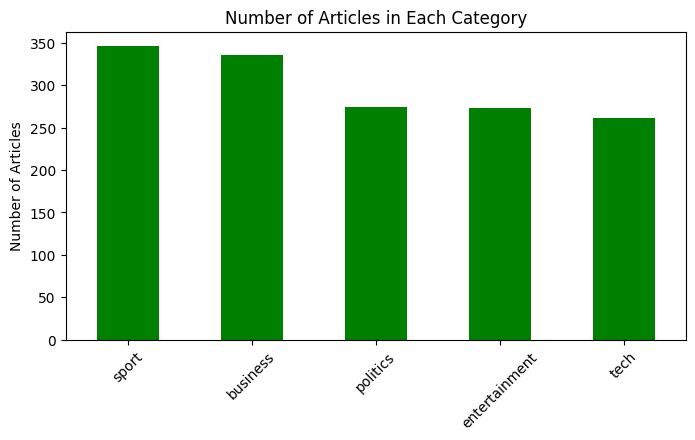

In [ ]:
category_counts = train_df['Category'].value_counts()

plt.figure(figsize=(8, 4))
category_counts.plot(kind='bar', color='green')
plt.title('Number of Articles in Each Category')
#plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

train_df['text_length'] = train_df['Text'].apply(len)
text_length_stats = train_df['text_length'].describe()

#category_counts, text_length_stats

Statistics on Text Length:
count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: text_length, dtype: float64


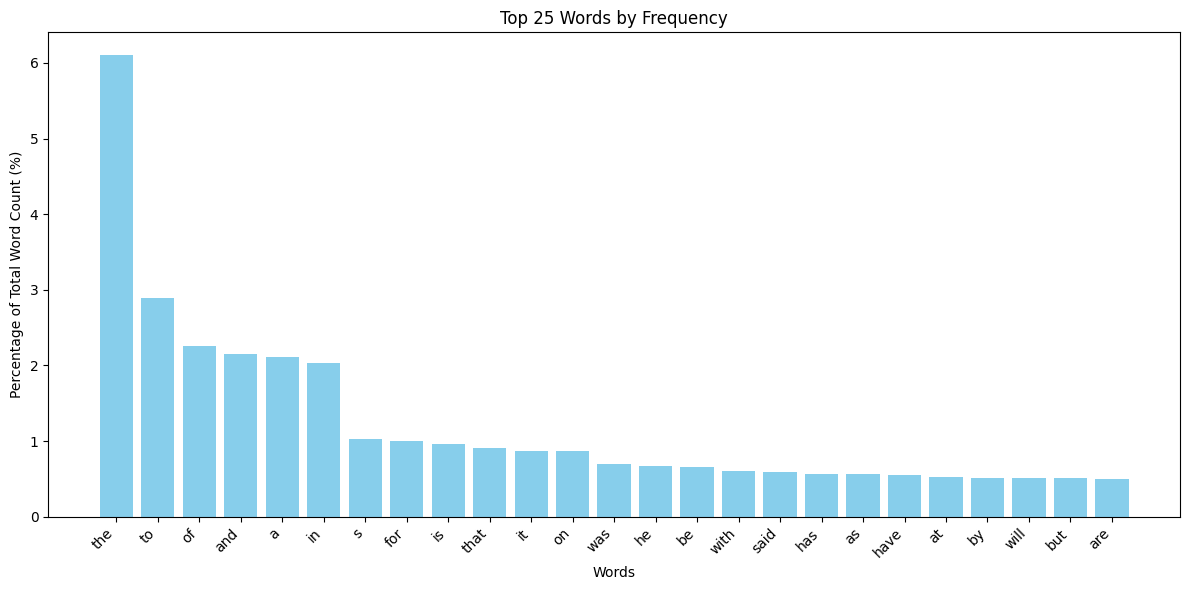

In [ ]:
# Computing statistics on text length
train_df['text_length'] = train_df['Text'].apply(len)
text_length_stats = train_df['text_length'].describe()

print("Statistics on Text Length:")
print(text_length_stats)

frequency = train_df['Text'].str.split(expand=True).unstack().value_counts()
freqplot = frequency[:25] / np.sum(frequency) * 100

#Word frequency plot of top 25 words
plt.figure(figsize=(12, 6))
plt.bar(freqplot.index, freqplot.values, color='skyblue')
plt.title('Top 25 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Percentage of Total Word Count (%)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

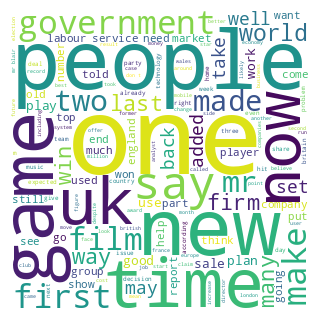

In [ ]:
def generate_wordcloud(text_series, additional_stopwords=None, width=300, height=300, background_color='white', min_font_size=5):
    combined_text = ' '.join(text_series.astype(str).str.lower())

    stopwords = set(STOPWORDS)
    if additional_stopwords:
        stopwords.update(additional_stopwords)

    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color=background_color,
        stopwords=stopwords,
        min_font_size=min_font_size
    ).generate(combined_text)

    plt.figure(figsize=(3, 3), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

additional_stopwords = ["said", "will", "s", "us", "year"]
generate_wordcloud(train_df['Text'], additional_stopwords=additional_stopwords)


### **Data Preprocessing**

In [ ]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    ## clean (convert to lowercase and remove punctuations and
    # characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in
                    lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words
lst_stopwords = list(stopwords)

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
train_df['Text'] = train_df.Text.apply(lambda x:
          preprocess_text(x, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

test_df['Text'] = test_df.Text.apply(lambda x:
          preprocess_text(x, flg_stemm=False, flg_lemm=True,
          lst_stopwords=lst_stopwords))

### **Model Building**

In [ ]:
X = train_df['Text']
y = train_df['Category']

# Tokenize text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences
max_sequence_length = 500
X_pad = pad_sequences(X_seq, maxlen=max_sequence_length)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_encoded = label_encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)


### **Using Deep Learning CNN**

In [ ]:
# Define CNN model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('cnn_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=16, validation_split=0.1, callbacks=[early_stopping, checkpoint])

# Evaluate the model
y_test_pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(y_test_encoded, y_test_pred))

Epoch 1/20
67/67 [==============================] - 8s 102ms/step - loss: 1.5864 - accuracy: 0.2435 - val_loss: 1.5223 - val_accuracy: 0.5333
Epoch 2/20
67/67 [==============================] - 7s 109ms/step - loss: 1.1469 - accuracy: 0.6651 - val_loss: 0.7765 - val_accuracy: 0.7417
Epoch 3/20
67/67 [==============================] - 7s 104ms/step - loss: 0.3994 - accuracy: 0.8946 - val_loss: 0.3138 - val_accuracy: 0.8917
Epoch 4/20
67/67 [==============================] - 7s 107ms/step - loss: 0.0973 - accuracy: 0.9851 - val_loss: 0.2018 - val_accuracy: 0.9333
Epoch 5/20
67/67 [==============================] - 7s 104ms/step - loss: 0.0318 - accuracy: 0.9981 - val_loss: 0.1734 - val_accuracy: 0.9417
Epoch 6/20
67/67 [==============================] - 7s 101ms/step - loss: 0.0158 - accuracy: 0.9991 - val_loss: 0.1658 - val_accuracy: 0.9417
Epoch 7/20
67/67 [==============================] - 8s 115ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1554 - val_accuracy: 0.9500
Epoch 

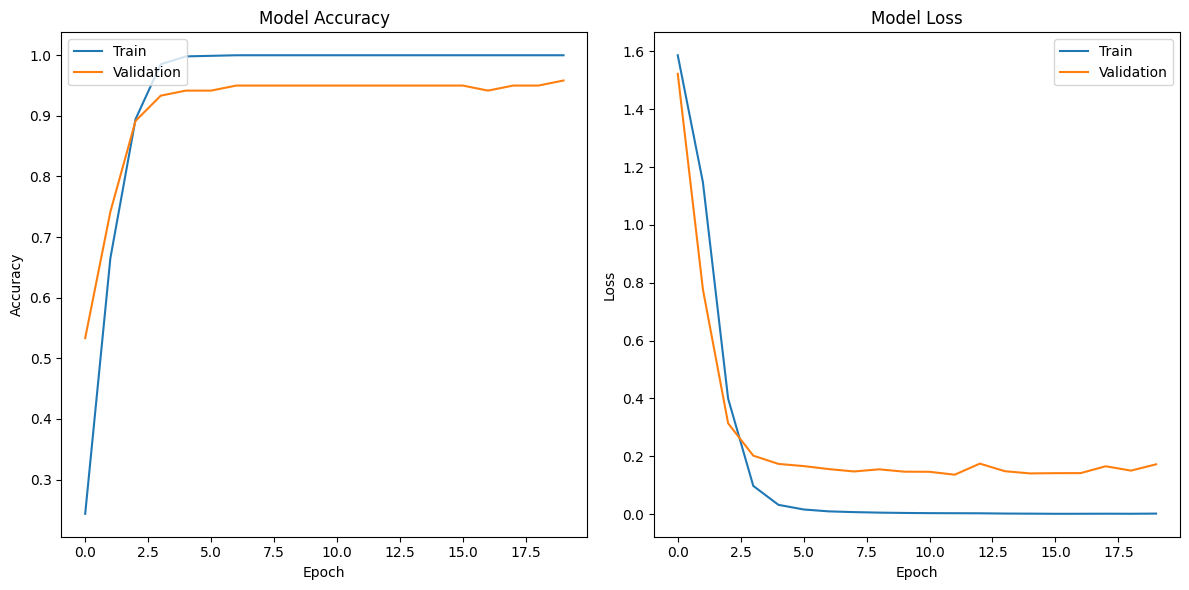

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


### **Deep Learning RNN_LSTM**

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_df['category_encoded'] = label_encoder.fit_transform(train_df['Category'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['Text'], train_df['category_encoded'], test_size=0.2, random_state=42)

# Tokenize text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_sequence_length = 500
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Define RNN model
model = Sequential([
    Embedding(input_dim=10000, output_dim=100),
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('rnn_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint])

# Evaluate the model
y_test_pred = np.argmax(model.predict(X_test_pad), axis=-1)

print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



Epoch 1/10
34/34 [==============================] - 64s 2s/step - loss: 1.5794 - accuracy: 0.3125 - val_loss: 1.5379 - val_accuracy: 0.6167
Epoch 2/10
34/34 [==============================] - 55s 2s/step - loss: 1.2291 - accuracy: 0.7500 - val_loss: 1.1264 - val_accuracy: 0.5833
Epoch 3/10
34/34 [==============================] - 53s 2s/step - loss: 0.6549 - accuracy: 0.8806 - val_loss: 0.7088 - val_accuracy: 0.7833
Epoch 4/10
34/34 [==============================] - 56s 2s/step - loss: 0.2588 - accuracy: 0.9543 - val_loss: 0.4357 - val_accuracy: 0.8500
Epoch 5/10
34/34 [==============================] - 55s 2s/step - loss: 0.0723 - accuracy: 0.9832 - val_loss: 0.3977 - val_accuracy: 0.8667
Epoch 6/10
34/34 [==============================] - 55s 2s/step - loss: 0.0373 - accuracy: 0.9944 - val_loss: 0.2540 - val_accuracy: 0.9250
Epoch 7/10
34/34 [==============================] - 54s 2s/step - loss: 0.0205 - accuracy: 0.9963 - val_loss: 0.3061 - val_accuracy: 0.8917
Epoch 8/10
34/34 [==

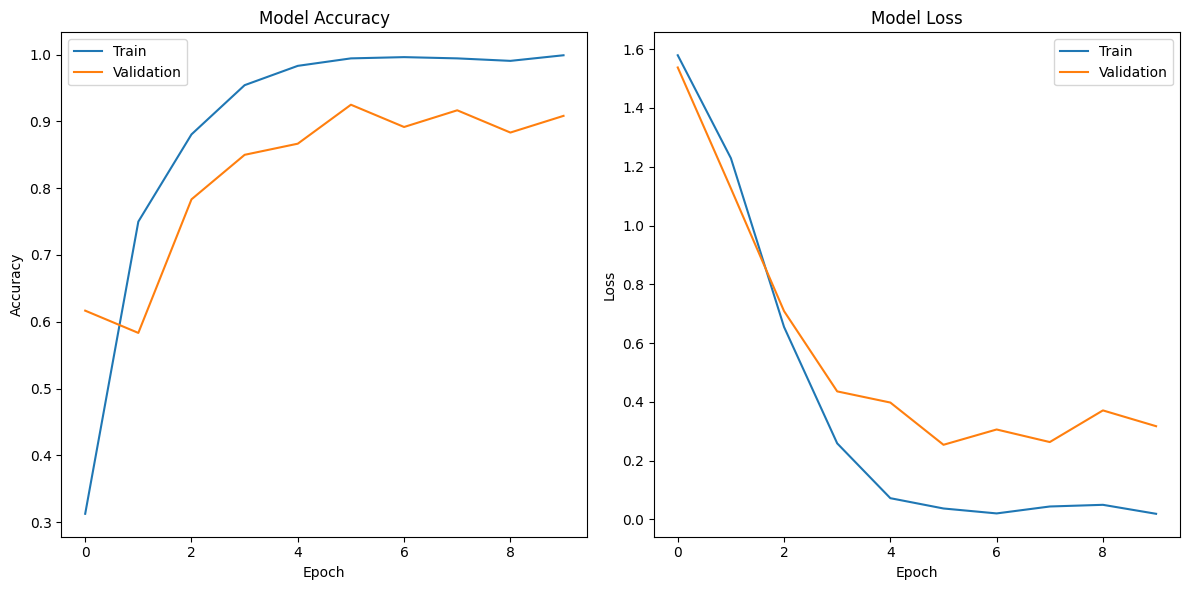

In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()


### **SVM Classifier**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [ ]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['Text'], train_df['Category'], test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_vec, y_train)

# Evaluate classifier
y_train_pred = svm_classifier.predict(X_train_vec)
y_test_pred = svm_classifier.predict(X_test_vec)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print classification report
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

# Save the model
joblib.dump(svm_classifier, 'svm_model.pkl')

Classification Report for Training Set:
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       261
entertainment       1.00      1.00      1.00       227
     politics       1.00      1.00      1.00       218
        sport       1.00      1.00      1.00       283
         tech       1.00      1.00      1.00       203

     accuracy                           1.00      1192
    macro avg       1.00      1.00      1.00      1192
 weighted avg       1.00      1.00      1.00      1192

Classification Report for Test Set:
               precision    recall  f1-score   support

     business       0.95      0.99      0.97        75
entertainment       0.98      1.00      0.99        46
     politics       0.96      0.95      0.95        56
        sport       1.00      1.00      1.00        63
         tech       1.00      0.95      0.97        58

     accuracy                           0.98       298
    macro avg       0.98      0.98     

['svm_model.pkl']

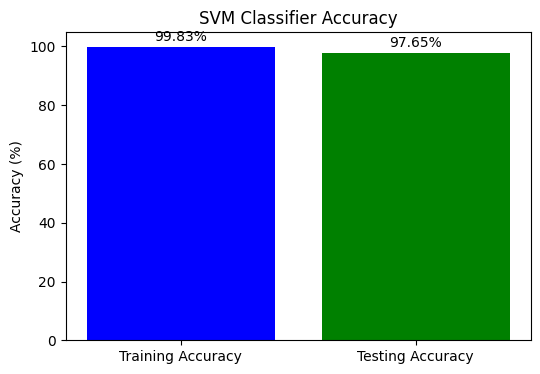

Model saved as 'svm_model.pkl'
Accuracy plot saved as 'svm_accuracy.png'


In [ ]:

# Plotting accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy*100, test_accuracy*100], color=['blue', 'green'])
plt.title('SVM Classifier Accuracy')
plt.ylabel('Accuracy (%)')

# Annotate bars with percentages
for i, v in enumerate([train_accuracy*100, test_accuracy*100]):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', color='black', fontsize=10)

plt.savefig('svm_accuracy.png')
plt.show()

print("Model saved as 'svm_model.pkl'")
print("Accuracy plot saved as 'svm_accuracy.png'")

### **MultinomialNB**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['Text'], train_df['Category'], test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Evaluate classifier
y_train_pred = nb_classifier.predict(X_train_vec)
y_test_pred = nb_classifier.predict(X_test_vec)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_loss = 1 - train_accuracy
test_loss = 1 - test_accuracy

# Print classification report
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

# Save the model
joblib.dump(nb_classifier, 'naive_bayes_model.pkl')



Classification Report for Training Set:
               precision    recall  f1-score   support

     business       0.99      1.00      0.99       261
entertainment       1.00      1.00      1.00       227
     politics       1.00      0.99      0.99       218
        sport       1.00      1.00      1.00       283
         tech       0.99      0.99      0.99       203

     accuracy                           0.99      1192
    macro avg       0.99      0.99      0.99      1192
 weighted avg       0.99      0.99      0.99      1192

Classification Report for Test Set:
               precision    recall  f1-score   support

     business       0.96      0.97      0.97        75
entertainment       1.00      0.98      0.99        46
     politics       0.91      0.95      0.93        56
        sport       0.97      1.00      0.98        63
         tech       0.98      0.91      0.95        58

     accuracy                           0.96       298
    macro avg       0.97      0.96     

['naive_bayes_model.pkl']

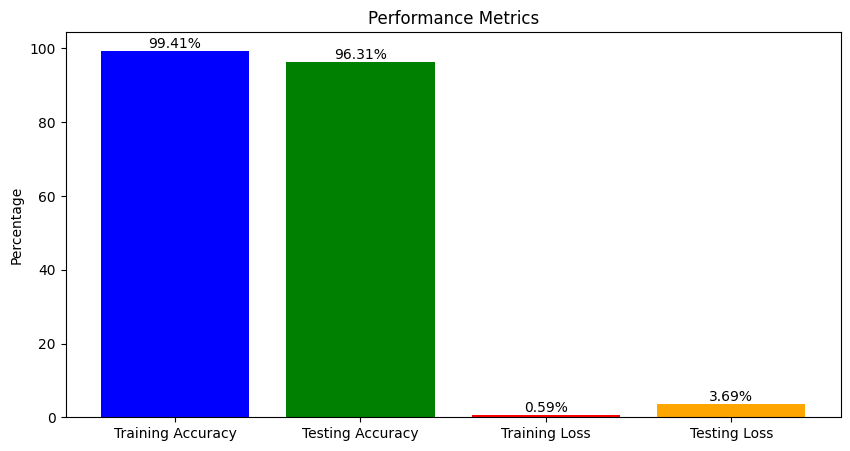

Model saved as 'naive_bayes_model.pkl'
Performance metrics plotted and saved as 'performance_metrics.png'


In [ ]:
# Plotting accuracy and loss
labels = ['Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss']
values = [train_accuracy*100, test_accuracy*100, train_loss*100, test_loss*100]

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color=['blue', 'green', 'red', 'orange'])
plt.title('Performance Metrics')
plt.ylabel('Percentage')

# Annotate bars with percentages
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}%',
             ha='center', va='bottom', color='black', fontsize=10)

plt.savefig('performance_metrics.png')
plt.show()

print("Model saved as 'naive_bayes_model.pkl'")
print("Performance metrics plotted and saved as 'performance_metrics.png'")


### **Logistic Regression Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df['Text'], train_df['Category'], test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Logistic Regression classifier
logistic_classifier = LogisticRegression(max_iter=1000)
logistic_classifier.fit(X_train_vec, y_train)

# Evaluate classifier
y_train_pred = logistic_classifier.predict(X_train_vec)
y_test_pred = logistic_classifier.predict(X_test_vec)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print classification report
print("Classification Report for Training Set:")
print(classification_report(y_train, y_train_pred))
print("Classification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

# Save the model
joblib.dump(logistic_classifier, 'logistic_regression_model.pkl')


Classification Report for Training Set:
               precision    recall  f1-score   support

     business       1.00      1.00      1.00       261
entertainment       1.00      1.00      1.00       227
     politics       1.00      1.00      1.00       218
        sport       1.00      1.00      1.00       283
         tech       1.00      1.00      1.00       203

     accuracy                           1.00      1192
    macro avg       1.00      1.00      1.00      1192
 weighted avg       1.00      1.00      1.00      1192

Classification Report for Test Set:
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        75
entertainment       0.98      1.00      0.99        46
     politics       0.96      0.95      0.95        56
        sport       0.95      1.00      0.98        63
         tech       0.98      0.93      0.96        58

     accuracy                           0.97       298
    macro avg       0.97      0.97     

['logistic_regression_model.pkl']

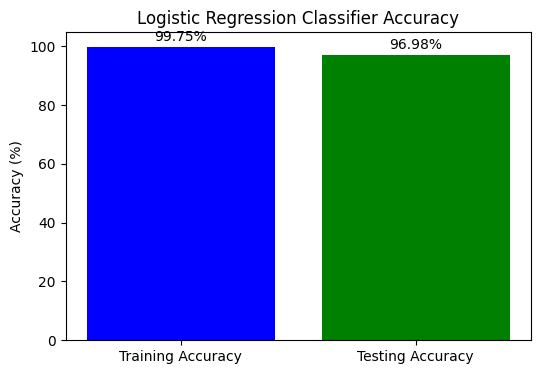

Model saved as 'logistic_regression_model.pkl'
Accuracy plot saved as 'logistic_regression_accuracy.png'


In [ ]:

# Plotting accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy*100, test_accuracy*100], color=['blue', 'green'])
plt.title('Logistic Regression Classifier Accuracy')
plt.ylabel('Accuracy (%)')

# Annotate bars with percentages
for i, v in enumerate([train_accuracy*100, test_accuracy*100]):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', color='black', fontsize=10)

plt.savefig('logistic_regression_accuracy.png')
plt.show()

print("Model saved as 'logistic_regression_model.pkl'")
print("Accuracy plot saved as 'logistic_regression_accuracy.png'")

### **BERT**

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)

# Get all uninque classes
possible_labels = train_df['Category'].unique()
# Generate a dict were every class map to an id
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
# Get a new encoded category column (category_id)
train_df['category_id'] = train_df.Category.map(label_dict)

train_df['label'] = train_df['Category'].replace(label_dict)

In [ ]:
# Splite the data
X_train, X_val, y_train, y_val = train_test_split(train_df.index.values,
                                                  train_df.label.values,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  stratify=train_df.label.values)

# Specify the data_type (train and val)
train_df['data_type'] = ['not_set']*train_df.shape[0]

train_df.loc[X_train, 'data_type'] = 'train'
train_df.loc[X_val, 'data_type'] = 'val'

train_df.groupby(['Category', 'label', 'data_type']).count()

ArticleId  Text  category_id
Category      label data_type                              
business      0     train            302   302          302
                    val               34    34           34
entertainment 4     train            246   246          246
                    val               27    27           27
politics      2     train            247   247          247
                    val               27    27           27
sport         3     train            311   311          311
                    val               35    35           35
tech          1     train            235   235          235
                    val               26    26           26

In [ ]:
from sklearn.metrics import f1_score

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import BertTokenizer, AutoTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification, AutoModel, AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TextClassificationPipeline

In [ ]:
# Intiate a bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

# Encode the train dataq
# Truncation is a must as we know that we have sequences larger than 512
encoded_data_train = tokenizer.batch_encode_plus(
    train_df[train_df.data_type=='train'].Text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation = True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    train_df[train_df.data_type=='val'].Text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation = True,
    max_length=512,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df[train_df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(train_df[train_df.data_type=='val'].label.values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# instantiate a bert model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare tensor datasets
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
# Seeding all
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

# Save the model
torch.save(model.state_dict(), f'finetuned_BERT.model')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/447 [00:00<?, ?it/s]

In [ ]:
val_loss, predictions, true_vals = evaluate(dataloader_validation)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Validation loss: {val_loss}')
tqdm.write(f'F1 Score (Weighted): {val_f1}')

Validation loss: 0.1323445807932876
F1 Score (Weighted): 0.9592918726288729


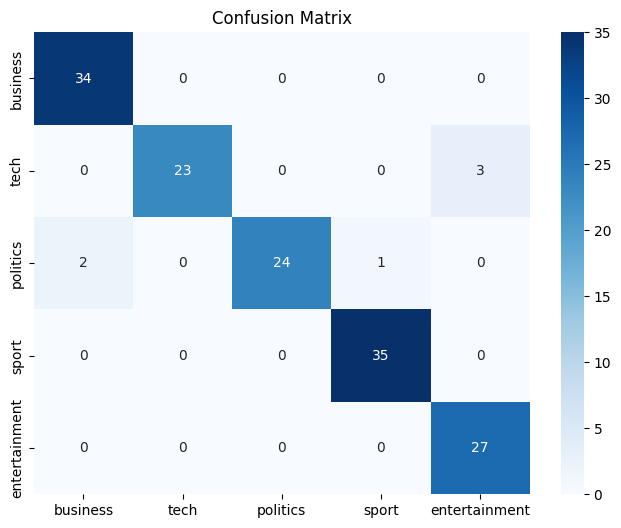

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define our class names
class_names = train_df['Category'].unique()

# Evaluate the model on the validation set to get predictions and true values
val_loss, predictions, true_vals = evaluate(dataloader_validation)

# Convert the predictions and true values to numpy arrays
predictions = np.argmax(predictions, axis=1)
true_vals = true_vals.flatten()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_vals, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()